In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score, f1_score,balanced_accuracy_score,accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer,PowerTransformer,QuantileTransformer,MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif,mutual_info_classif
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn.svm import SVC

Train a model to predict heart disease

In [2]:
df=pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Dataset Information:
This dataset includes the following features:

age: The age of the patient.

sex: Gender of the patient (0: female, 1: male).
cp: Type of chest pain.

trestbps: Resting blood pressure.

chol: Serum cholesterol.

fbs: Fasting blood sugar > 120 mg/dl.

restecg: Resting electrocardiographic results.

thalach: Maximum heart rate achieved.

exang: Exercise induced angina.

ca: Number of major vessels (0-4) colored by fluoroscopy

oldpeak: ST depression induced by exercise relative to rest

thal: Four unique results are available. The most common type is "2" (indicating a reversible defect), observed 166 times.

Exploratory Data Analysis

In [3]:
#check for nulls
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

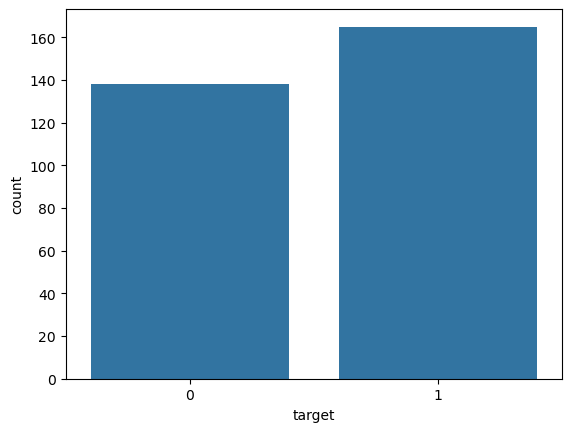

In [6]:
sns.countplot(x=df['target'])
None

As we see, we have 165 people with heart disease and 138 without heart disease 

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


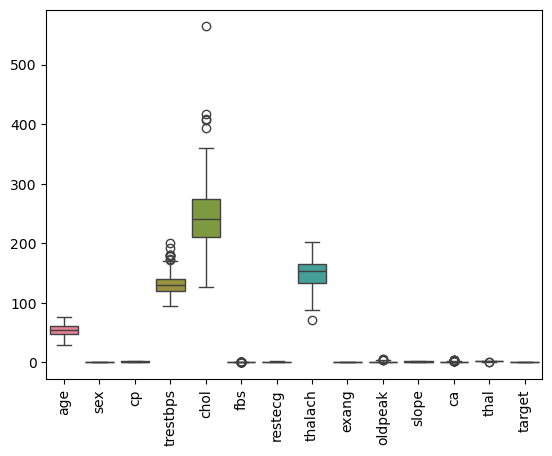

In [8]:
#check for outliers
gr = sns.boxplot(data=df)
gr.set_xticks(ticks=df.columns)
gr.set_xticklabels(labels=df.columns, rotation=90)
None

In [9]:
possible_outliers=['age','trestbps','chol','thalach','oldpeak']
df_outliers=df[possible_outliers]
df_outliers

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6
...,...,...,...,...,...
298,57,140,241,123,0.2
299,45,110,264,132,1.2
300,68,144,193,141,3.4
301,57,130,131,115,1.2


In [10]:
Q1 = df[possible_outliers].quantile(0.25)
Q3 = df[possible_outliers].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[possible_outliers]< (Q1 - 1.5 * IQR)) | (df[possible_outliers] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

we found that:

trestbps: 9 outliers

chol: 5 outliers

thalach: 1 outlier

oldpeak: 5 outliers

age: No outliers

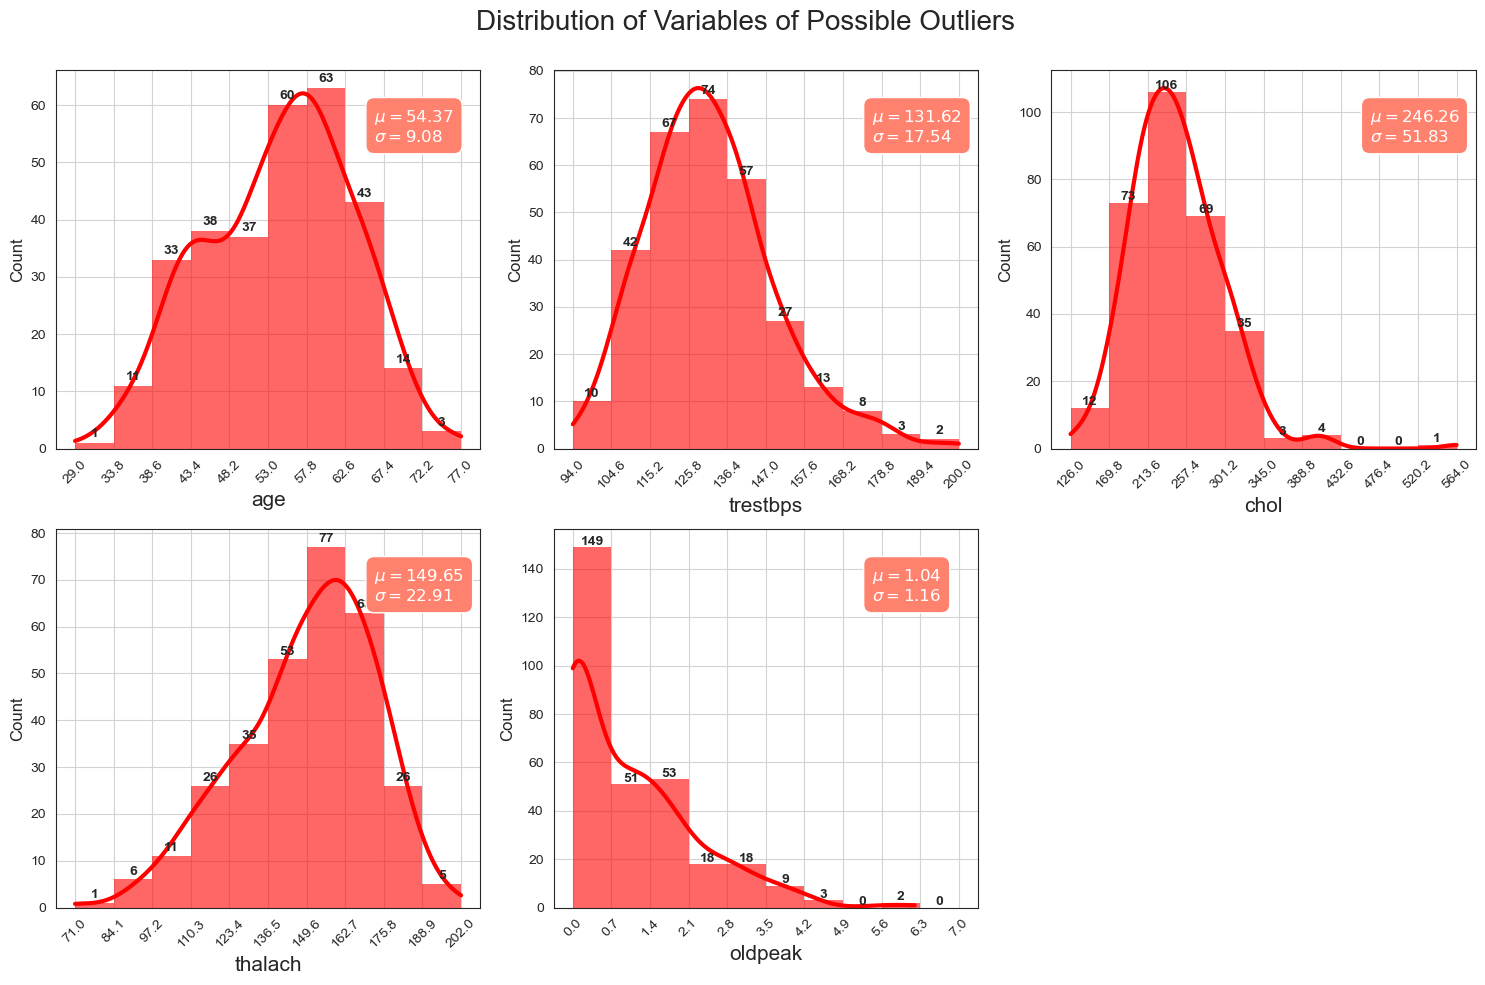

In [63]:
# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_outliers.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_outliers[col], 
                                     range=(np.floor(df_outliers[col].min()), np.ceil(df_outliers[col].max())))
    
    
    graph = sns.histplot(data=df_outliers, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_outliers[col].mean(),
        r'$\sigma=%.2f$' % df_outliers[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Variables of Possible Outliers', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [11]:
# Implementing one-hot encoding on the specified categorical features
df = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

In [12]:
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,0,False,False,False,True,False,False,False,True
299,45,1,110,264,0,132,0,1.2,1,0,0,False,False,True,True,False,False,False,True
300,68,1,144,193,1,141,0,3.4,1,2,0,False,False,False,True,False,False,False,True
301,57,1,130,131,0,115,1,1.2,1,1,0,False,False,False,True,False,False,False,True


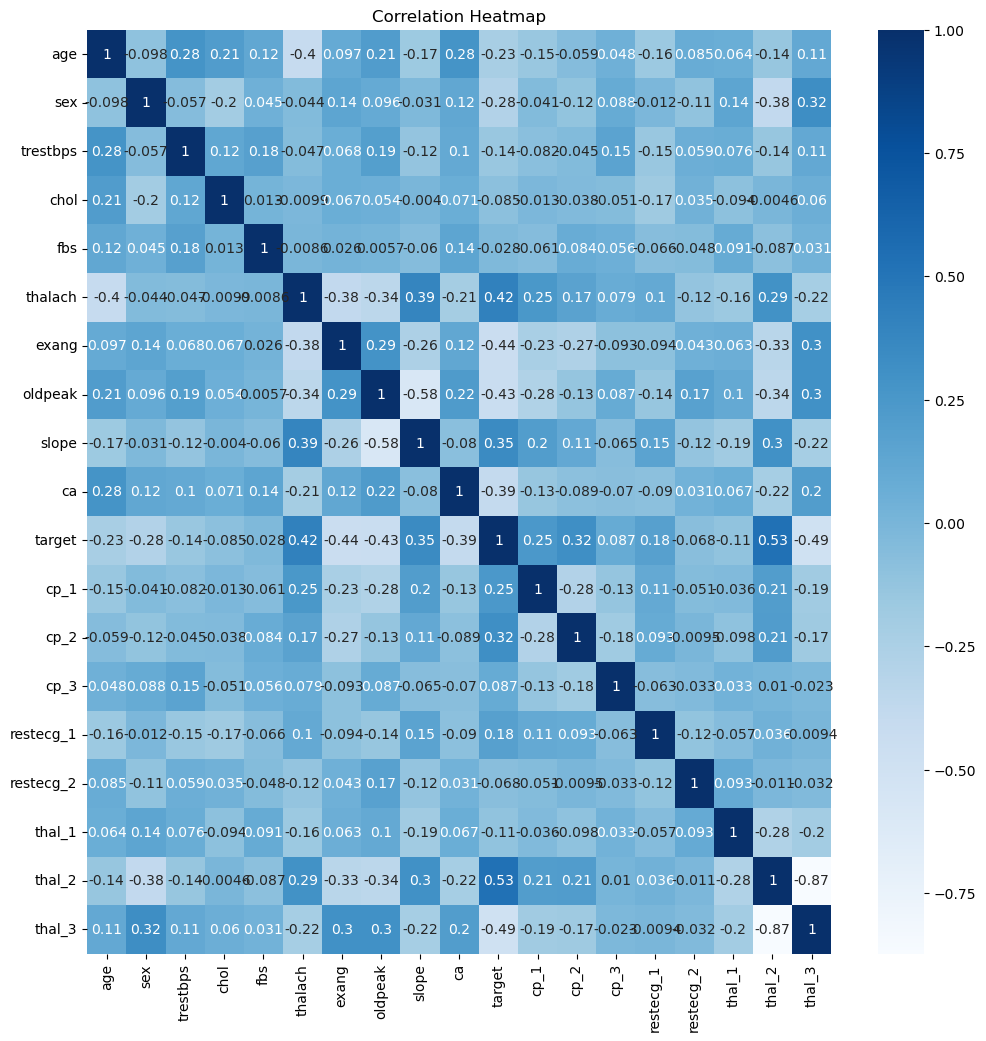

In [13]:
plt.figure(figsize = (12,12))
plt.title('Correlation Heatmap')
heatmap = sns.heatmap(df.corr(), annot = True, cmap='Blues')

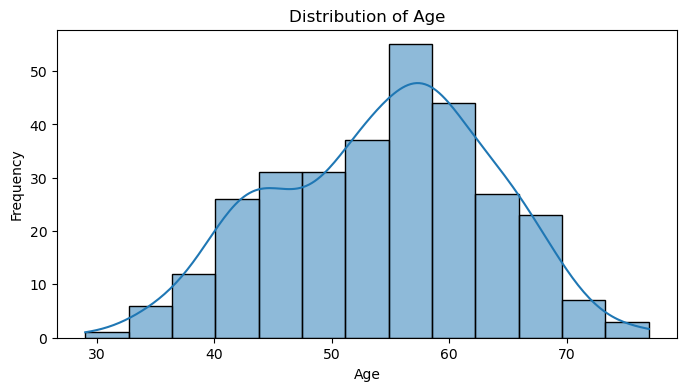

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=13, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Define model

In [15]:
X=df.drop('target',axis=1)

In [16]:
X

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,False,False,False,True,False,False,False,True
299,45,1,110,264,0,132,0,1.2,1,0,False,False,True,True,False,False,False,True
300,68,1,144,193,1,141,0,3.4,1,2,False,False,False,True,False,False,False,True
301,57,1,130,131,0,115,1,1.2,1,1,False,False,False,True,False,False,False,True


In [17]:
y=df['target']

In [18]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [19]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [20]:
#using the parameter : class_weight='balanced'
X=df.drop('target',axis=1)
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5,stratify=y)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
# random forest model creation
classifier = RandomForestClassifier(class_weight='balanced',random_state=42)
classifier.fit(X_train, y_train)
#predictions
predictions = classifier.predict(X_test)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))

=== Confusion Matrix ===
[[30  5]
 [ 8 33]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        35
           1       0.87      0.80      0.84        41

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76



Text(50.722222222222214, 0.5, 'Actual Label')

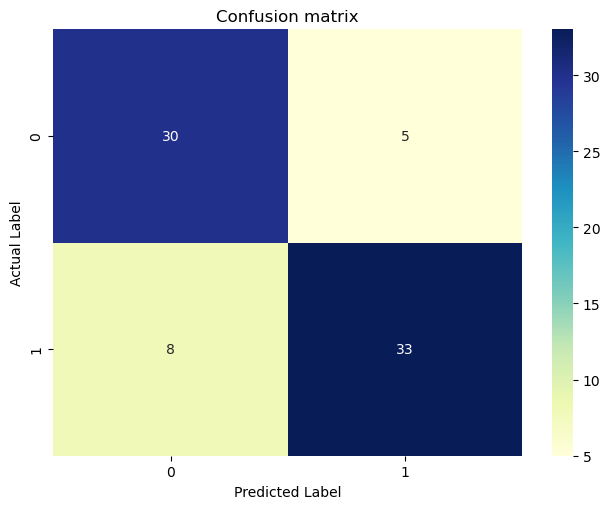

In [21]:
cnf_matrix2 = metrics.confusion_matrix(y_test,predictions)
cnf_matrix2
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#Create Heatmap
sns.heatmap(pd.DataFrame(cnf_matrix2), annot= True, cmap = "YlGnBu", fmt ="g")
plt.tight_layout()
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

Feature Selection

i) K-best

In [22]:
#apply SelectKBest to hole dataset class to extract top 10 best features 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y)
scaler = StandardScaler()

#number of top features we want
k = 18  
select_k_best=SelectKBest(mutual_info_classif, k = k)
X_train_kbest = select_k_best.fit_transform(X_train, y_train)
X_test_kbest = select_k_best.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train_kbest, y_train)
y_pred = model.predict(X_test_kbest)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Confusion Matrix ===
[[27  8]
 [ 7 34]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        35
           1       0.81      0.83      0.82        41

    accuracy                           0.80        76
   macro avg       0.80      0.80      0.80        76
weighted avg       0.80      0.80      0.80        76



In [23]:
features_names=X_train.columns
select_mask = select_k_best.get_support() #boolean array of seelcted features
selected_features_names = features_names[select_mask]

print("Selected features by SelectKBest:")
print(selected_features_names)

Selected features by SelectKBest:
Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'slope', 'ca', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2',
       'thal_1', 'thal_2', 'thal_3'],
      dtype='object')


ii) feature importance

In [24]:
importance = pd.Series(classifier.feature_importances_, index=list(X_train))
importance = importance/importance.max()
importance = importance.sort_values(ascending=False)

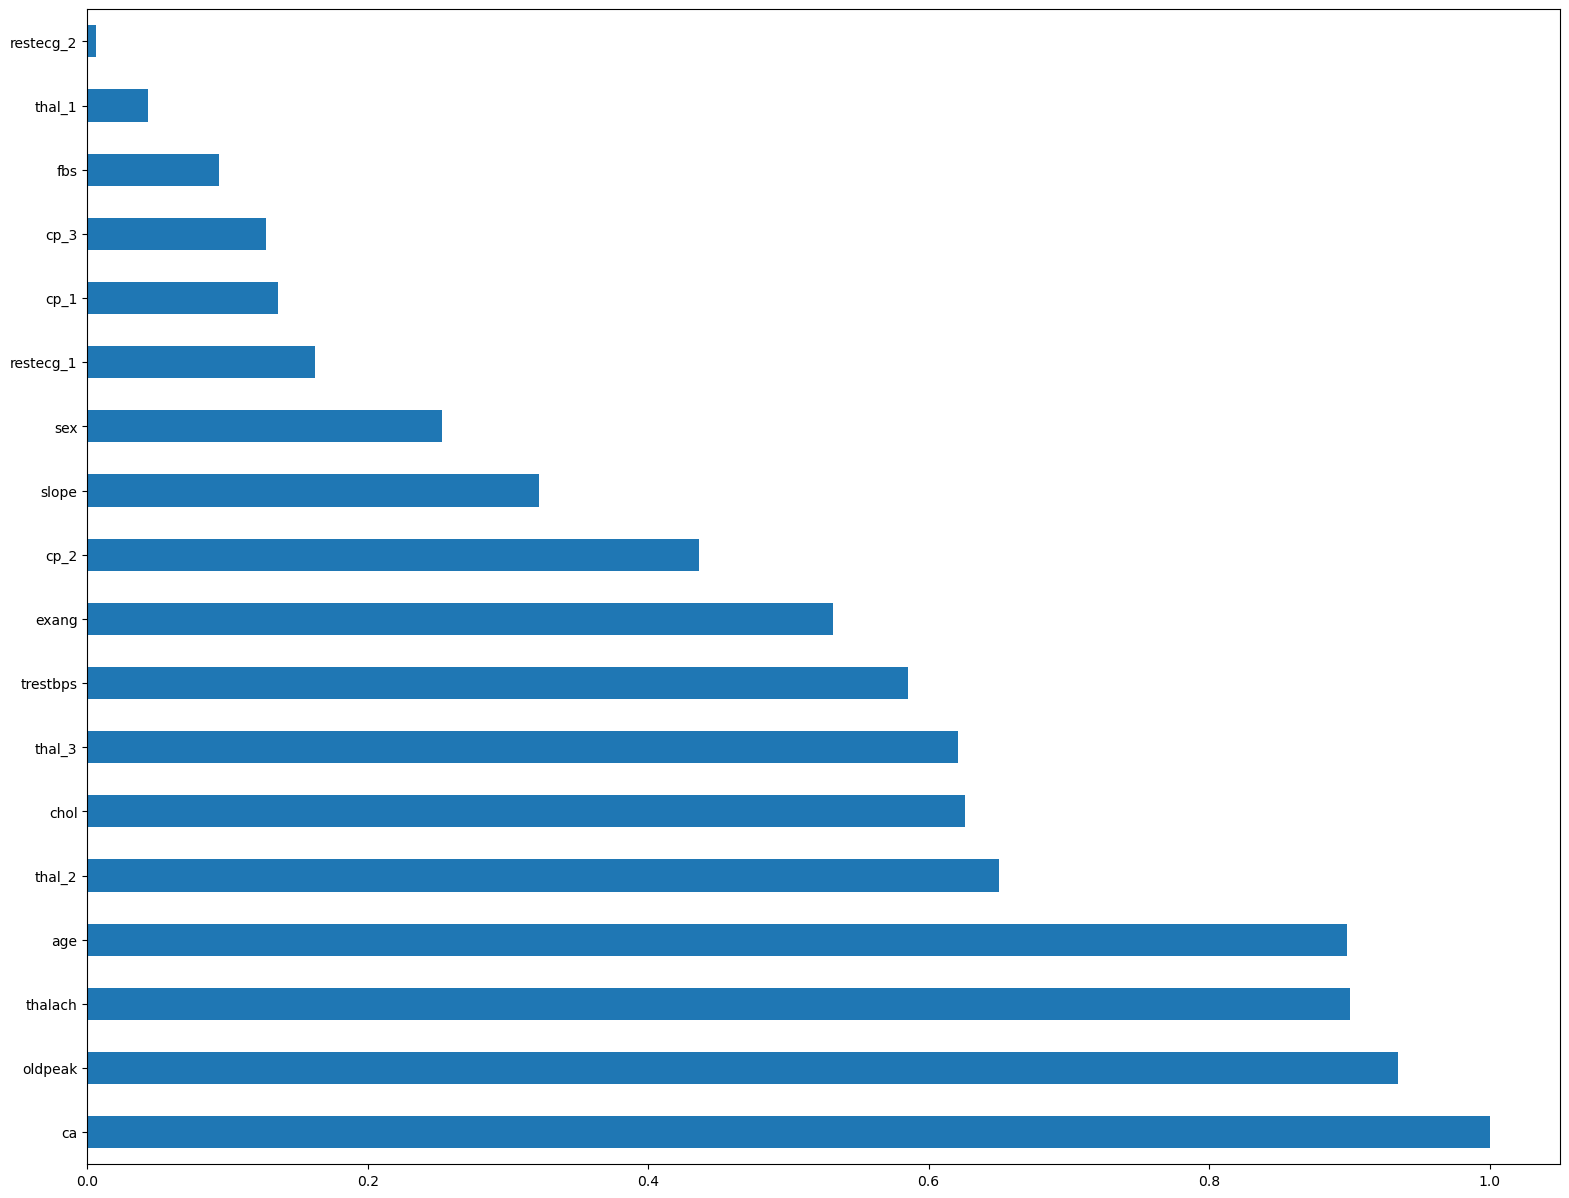

In [25]:
importance.plot.barh(figsize=(19,15))
None

iii) shap values

In [26]:
#shap values
# Fit Explainer

explainer = shap.Explainer(model.predict,X_test_sc)

#Calculate SHAP Values
shap_values = explainer(X_test_sc)

PermutationExplainer explainer: 77it [00:12,  1.48it/s]                        


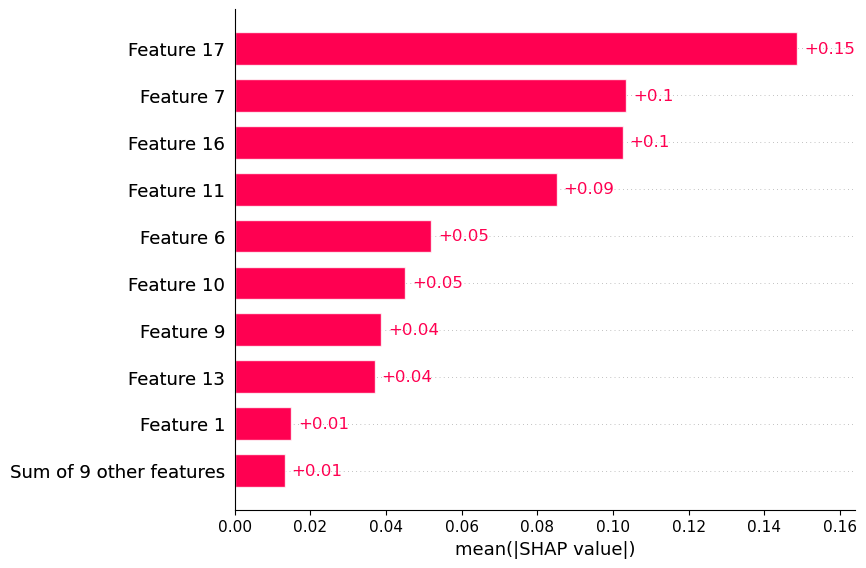

In [27]:
#Features Importances sorted for model
shap.plots.bar(shap_values)

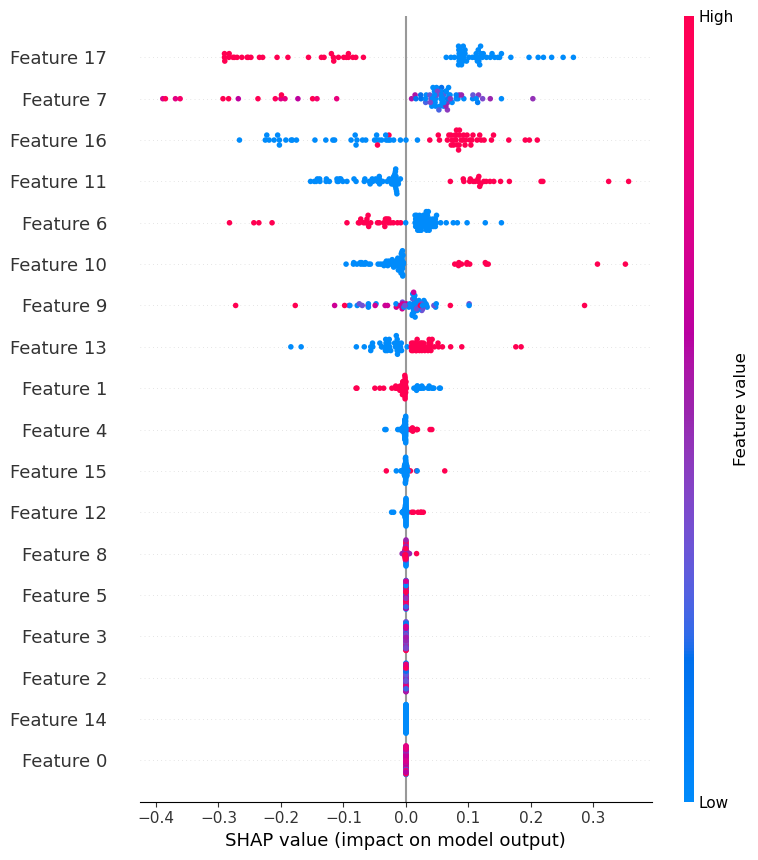

In [28]:
shap.summary_plot(shap_values)

iv)MRMR (Maximum Relevance-Minimum Redundancy)

In [29]:
from mrmr import mrmr_classif

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y)
#run mrmr on train set
mrmr_classif(X_train,y_train,K=40)

#scaling with Standard Scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

100%|██████████| 18/18 [00:05<00:00,  3.41it/s]


In [31]:
#Make the X_train_sc into a df

X_train_sc_df = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_train_sc_df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,-1.356854,0.640264,0.925841,0.001120,-0.448395,1.243151,-0.674632,-0.194238,0.967576,1.203164,-0.419721,-0.653967,3.514675,-1.013304,-0.13393,-0.256374,0.944281,-0.817996
1,0.403808,-1.561856,-0.101307,-0.917719,-0.448395,-0.802689,-0.674632,-0.368860,-0.635634,-0.713455,-0.419721,-0.653967,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
2,-0.366481,0.640264,-1.813221,-0.428975,-0.448395,-0.280347,1.482290,0.155006,-0.635634,-0.713455,-0.419721,1.529129,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
3,-0.036357,0.640264,-0.443690,0.431214,-0.448395,-1.760316,1.482290,1.028115,-0.635634,0.244854,-0.419721,-0.653967,-0.284521,-1.013304,-0.13393,-0.256374,-1.059007,1.222500
4,-0.476523,-1.561856,-0.671945,0.001120,-0.448395,0.546695,-0.674632,0.067695,0.967576,-0.713455,2.382534,-0.653967,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1.504222,-1.561856,-0.671945,-0.644023,-0.448395,-1.499145,-0.674632,0.416938,-0.635634,-0.713455,-0.419721,1.529129,-0.284521,-1.013304,-0.13393,-0.256374,0.944281,-0.817996
223,0.073684,-1.561856,0.012820,1.916997,-0.448395,0.720809,-0.674632,0.155006,0.967576,-0.713455,2.382534,-0.653967,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
224,1.174098,-1.561856,1.039969,-0.370326,-0.448395,-1.542673,-0.674632,-0.019616,-0.635634,2.161473,-0.419721,-0.653967,-0.284521,-1.013304,-0.13393,-0.256374,-1.059007,1.222500
225,-0.146399,0.640264,-0.500754,0.744011,-0.448395,-2.369715,1.482290,0.853493,-0.635634,1.203164,-0.419721,-0.653967,-0.284521,0.986870,-0.13393,-0.256374,-1.059007,1.222500


In [32]:
#Make the X_test_sc into a df

X_test_sc_df = pd.DataFrame(X_test_sc, columns = X_test.columns)
X_test_sc_df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,-1.576937,0.640264,0.469331,-0.878620,-0.448395,1.243151,1.482290,0.329628,0.967576,-0.713455,-0.419721,-0.653967,3.514675,0.986870,-0.13393,-0.256374,-1.059007,1.222500
1,0.843974,-1.561856,0.469331,2.933584,-0.448395,0.329052,-0.674632,0.155006,-0.635634,-0.713455,-0.419721,-0.653967,-0.284521,-1.013304,-0.13393,-0.256374,0.944281,-0.817996
2,1.064057,0.640264,0.469331,1.780148,-0.448395,0.372581,-0.674632,-0.892725,0.967576,-0.713455,-0.419721,1.529129,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
3,0.183725,-1.561856,3.893158,0.861309,2.230176,-0.715632,1.482290,2.599711,-2.238843,1.203164,-0.419721,-0.653967,-0.284521,-1.013304,-0.13393,-0.256374,-1.059007,1.222500
4,0.293767,-1.561856,-0.671945,2.151594,-0.448395,0.590224,1.482290,-0.368860,0.967576,-0.713455,-0.419721,-0.653967,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.284139,0.640264,1.610607,0.040219,-0.448395,-1.281502,1.482290,-0.892725,-0.635634,2.161473,2.382534,-0.653967,-0.284521,0.986870,-0.13393,3.900549,-1.059007,-0.817996
72,-1.026730,-1.561856,-1.128455,-1.641061,-0.448395,-0.497989,-0.674632,-0.892725,-0.635634,-0.713455,2.382534,-0.653967,-0.284521,0.986870,-0.13393,-0.256374,0.944281,-0.817996
73,-0.036357,0.640264,-0.386626,0.568063,-0.448395,0.111410,-0.674632,-0.456171,-2.238843,0.244854,-0.419721,1.529129,-0.284521,-1.013304,-0.13393,-0.256374,0.944281,-0.817996
74,-2.787392,0.640264,-0.101307,-0.780871,-0.448395,2.287835,-0.674632,-0.892725,0.967576,-0.713455,2.382534,-0.653967,-0.284521,-1.013304,-0.13393,-0.256374,0.944281,-0.817996


In [33]:
mrmr_classif(X_train_sc_df, y_train.values, K=18)

100%|██████████| 18/18 [00:05<00:00,  3.14it/s]


['thal_2',
 'chol',
 'exang',
 'cp_2',
 'ca',
 'oldpeak',
 'thal_3',
 'thalach',
 'slope',
 'sex',
 'restecg_1',
 'cp_1',
 'trestbps',
 'age',
 'restecg_2',
 'thal_1',
 'cp_3',
 'fbs']

In [34]:
#model predict with MRMR
selected_features = mrmr_classif(X_train_sc_df, y_train.values, K=14)
selected_features

100%|██████████| 14/14 [00:02<00:00,  5.15it/s]


['thal_2',
 'chol',
 'exang',
 'cp_2',
 'ca',
 'oldpeak',
 'thal_3',
 'thalach',
 'slope',
 'sex',
 'restecg_1',
 'cp_1',
 'trestbps',
 'age']

In [35]:
X_test_sc_df[selected_features]

,thal_2,chol,exang,cp_2,ca,oldpeak,thal_3,thalach,slope,sex,restecg_1,cp_1,trestbps,age
0,-1.059007,-0.878620,1.482290,-0.653967,-0.713455,0.329628,1.222500,1.243151,0.967576,0.640264,0.986870,-0.419721,0.469331,-1.576937
1,0.944281,2.933584,-0.674632,-0.653967,-0.713455,0.155006,-0.817996,0.329052,-0.635634,-1.561856,-1.013304,-0.419721,0.469331,0.843974
2,0.944281,1.780148,-0.674632,1.529129,-0.713455,-0.892725,-0.817996,0.372581,0.967576,0.640264,0.986870,-0.419721,0.469331,1.064057
3,-1.059007,0.861309,1.482290,-0.653967,1.203164,2.599711,1.222500,-0.715632,-2.238843,-1.561856,-1.013304,-0.419721,3.893158,0.183725
4,0.944281,2.151594,1.482290,-0.653967,-0.713455,-0.368860,-0.817996,0.590224,0.967576,-1.561856,0.986870,-0.419721,-0.671945,0.293767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.059007,0.040219,1.482290,-0.653967,2.161473,-0.892725,-0.817996,-1.281502,-0.635634,0.640264,0.986870,2.382534,1.610607,1.284139
72,0.944281,-1.641061,-0.674632,-0.653967,-0.713455,-0.892725,-0.817996,-0.497989,-0.635634,-1.561856,0.986870,2.382534,-1.128455,-1.026730
73,0.944281,0.568063,-0.674632,1.529129,0.244854,-0.456171,-0.817996,0.111410,-2.238843,0.640264,-1.013304,-0.419721,-0.386626,-0.036357
74,0.944281,-0.780871,-0.674632,-0.653967,-0.713455,-0.892725,-0.817996,2.287835,0.967576,0.640264,-1.013304,2.382534,-0.101307,-2.787392


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y)

#scaling with Standard Scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_train_sc_df = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_test_sc_df = pd.DataFrame(X_test_sc, columns = X_test.columns)
selected_features = mrmr_classif(X_train_sc_df, y_train.values, K=15)
X_train_mrmr = X_train_sc_df[selected_features]
X_test_mrmr = X_test_sc_df[selected_features]

model = RandomForestClassifier()
model.fit(X_train_mrmr, y_train)

y_pred = model.predict(X_test_mrmr)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

=== Confusion Matrix ===
[[27  8]
 [ 9 32]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.80      0.78      0.79        41

    accuracy                           0.78        76
   macro avg       0.78      0.78      0.78        76
weighted avg       0.78      0.78      0.78        76



In [37]:
X_final=X[selected_features]

We see that MRMR has detter f1-scores than K-best.


In [38]:
random.seed(5)
X_train,X_test,y_train,y_test=train_test_split(X_final,y,random_state=5,stratify=y)
for scaler in [StandardScaler(),MinMaxScaler(),RobustScaler(),Normalizer(),PowerTransformer(),QuantileTransformer(),MaxAbsScaler()]:
            pipe=Pipeline([
                ("scaler",scaler),
                ("classifier",RandomForestClassifier(random_state=5))
            ])

            
            pipe.fit(X_train,y_train)
            y_predict=pipe.predict(X_test)
            print(scaler,"with score",f1_score(y_test,y_predict,average='macro'))

StandardScaler() with score 0.788888888888889
MinMaxScaler() with score 0.788888888888889
RobustScaler() with score 0.788888888888889
Normalizer() with score 0.8137254901960784
PowerTransformer() with score 0.788888888888889
QuantileTransformer() with score 0.788888888888889
MaxAbsScaler() with score 0.788888888888889


In [39]:
X_train,X_test,y_train,y_test=train_test_split(X_final,y,random_state=5,stratify=y)
models={'Model':[],"F1_score":[]}
for classif in [RandomForestClassifier(),GradientBoostingClassifier(),LGBMClassifier(),XGBClassifier(),AdaBoostClassifier(),GaussianNB(),CategoricalNB(),SVC()]:
            pipe=Pipeline([("scaler",Normalizer()),
                ("classifier",classif)
               
            ])

            
            
            pipe.fit(X_train,y_train)
            y_predict=pipe.predict(X_test)
            models["Model"].append(str(classif))
            models["F1_score"].append(f1_score(y_test,y_predict,average='macro'))
            print(classif,"with score",f1_score(y_test,y_predict,average='macro'))

RandomForestClassifier() with score 0.867595818815331
GradientBoostingClassifier() with score 0.7731343283582088
[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [40]:
pd.DataFrame(models)

,Model,F1_score
0,RandomForestClassifier(),0.867596
1,GradientBoostingClassifier(),0.773134
2,LGBMClassifier(),0.735192
3,"XGBClassifier(base_score=None, booster=None, c...",0.828204
4,AdaBoostClassifier(),0.801774
5,GaussianNB(),0.828204
6,CategoricalNB(),0.350427
7,SVC(),0.660714


Finally we choose Gaussian Naive Bayes algorithm and Normalizer scaler

In [53]:
#Gaussian Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=0,stratify=y)

#scaling with Standard Scaler
scaler = Normalizer()

# Fit the scaler to the training data and transform it
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

model_G = GaussianNB()
model_G.fit(X_train_sc, y_train)

y_pred = model_G.predict(X_test_sc)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Confusion Matrix ===
[[27  8]
 [ 6 35]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.81      0.85      0.83        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.82        76



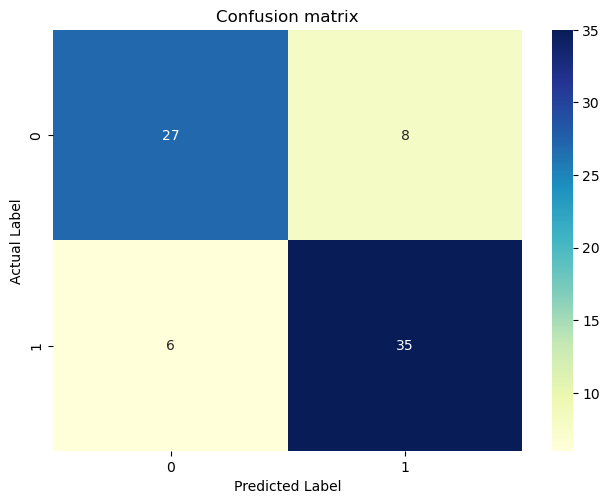

In [54]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cnf_matrix
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#Create Heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot= True, cmap = "YlGnBu", fmt ="g")
plt.tight_layout()
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
None

In [49]:
#Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=0,stratify=y)

#scaling with Standard Scaler
scaler = Normalizer()

# Fit the scaler to the training data and transform it
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

model_rf = RandomForestClassifier()
model_rf.fit(X_train_sc, y_train)

y_pred = model_rf.predict(X_test_sc)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Confusion Matrix ===
[[28  7]
 [10 31]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        35
           1       0.82      0.76      0.78        41

    accuracy                           0.78        76
   macro avg       0.78      0.78      0.78        76
weighted avg       0.78      0.78      0.78        76



In [50]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df2 = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df2

In [52]:
evaluation_G = evaluate_model(model_G, X_test_sc, y_test, 'GNB')
evaluation_G

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
GNB,0.82,0.81,0.77,0.85,0.79,0.83,0.82,0.81,0.81,0.82


In [55]:
rf_evaluation = evaluate_model(model_rf, X_test_sc, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.74,0.82,0.8,0.76,0.77,0.78,0.78,0.78,0.78,0.78


In [56]:
# Concatenate the dataframes
all_evaluations = [evaluation_G, rf_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
GNB,0.82,0.81,0.77,0.85,0.79,0.83,0.82,0.81,0.81,0.82
RF,0.74,0.82,0.80,0.76,0.77,0.78,0.78,0.78,0.78,0.78


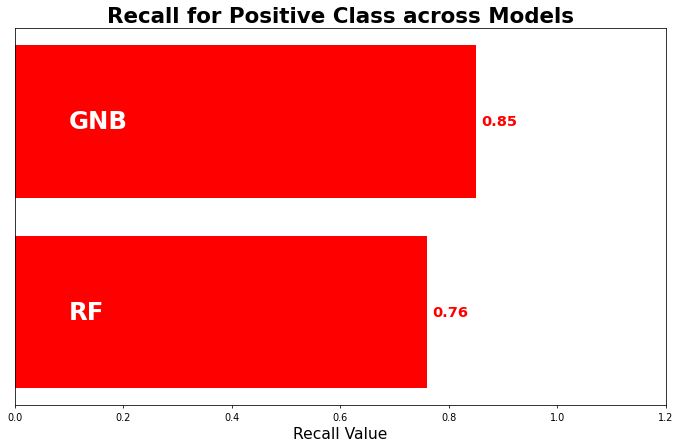

In [57]:
# Sort values based on 'recall_1'
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('Recall Value', fontsize=16)
plt.show()